# Correcting for Imbalanced Data

In [1]:
import joblib
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statistics import mean, mode
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Loading data
# file_path = Path("../data/myopia.csv")
file_path = Path("../eda/reduced_filtered_df.csv")
df = pd.read_csv(file_path)
df.head(5)

<IPython.core.display.Javascript object>

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen,MYOPIC
0,3.702,3.392,15.290000,4,1,1.358,8,0
1,3.462,3.514,15.520000,14,0,1.929,10,0
2,3.186,3.654,15.490000,12,1,1.433,16,0
3,3.732,3.584,15.080000,12,0,2.022,8,0
4,3.730,3.322,16.280001,4,0,1.783,9,0


In [3]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    233
1     34
Name: MYOPIC, dtype: int64

In [4]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()
X.head()

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen
0,3.702,3.392,15.290000,4,1,1.358,8
1,3.462,3.514,15.520000,14,0,1.929,10
2,3.186,3.654,15.490000,12,1,1.433,16
3,3.732,3.584,15.080000,12,0,2.022,8
4,3.730,3.322,16.280001,4,0,1.783,9


In [5]:
# Note the use of strategy since the dataset is imbalanced. 
# I am isolaating the X_test and y_test from the preprossing 
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, test_size=0.1, stratify=label)

<IPython.core.display.Javascript object>

In [6]:
y_train.value_counts()

0    209
1     31
Name: MYOPIC, dtype: int64

In [7]:
y_test.value_counts()

0    24
1     3
Name: MYOPIC, dtype: int64

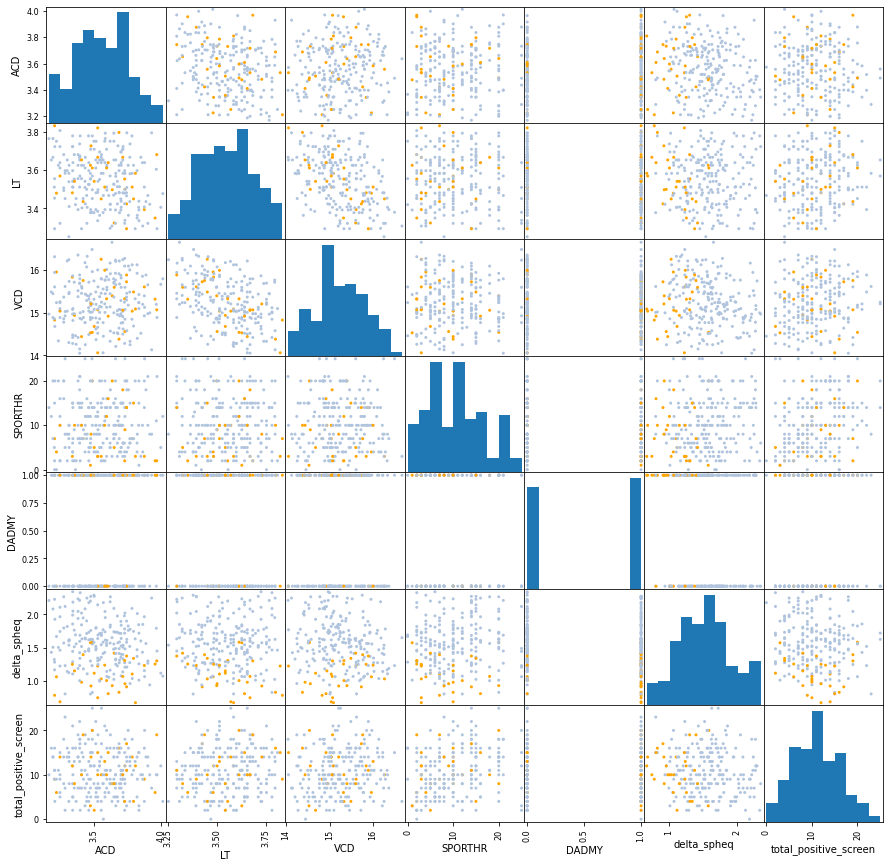

In [8]:
# original data
colors = {0:'lightsteelblue', 1:'orange'}
pd.plotting.scatter_matrix(X_train, alpha=1, figsize=(15,15), c=y_train.map(colors) );

## Balancing Data - RandomOverSampler

In [9]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints just duplicated and plotted on top
# Note that the raw data scatter has no transparency while all the other charts below have alpha=0.2
# This was done so the effects of duplicated datapoints could be identified
# In theory, only the minority class is being duplicated but this could cause some overfitting.  
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [10]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 209, 1: 31})
Resample dataset shape Counter({0: 209, 1: 209})


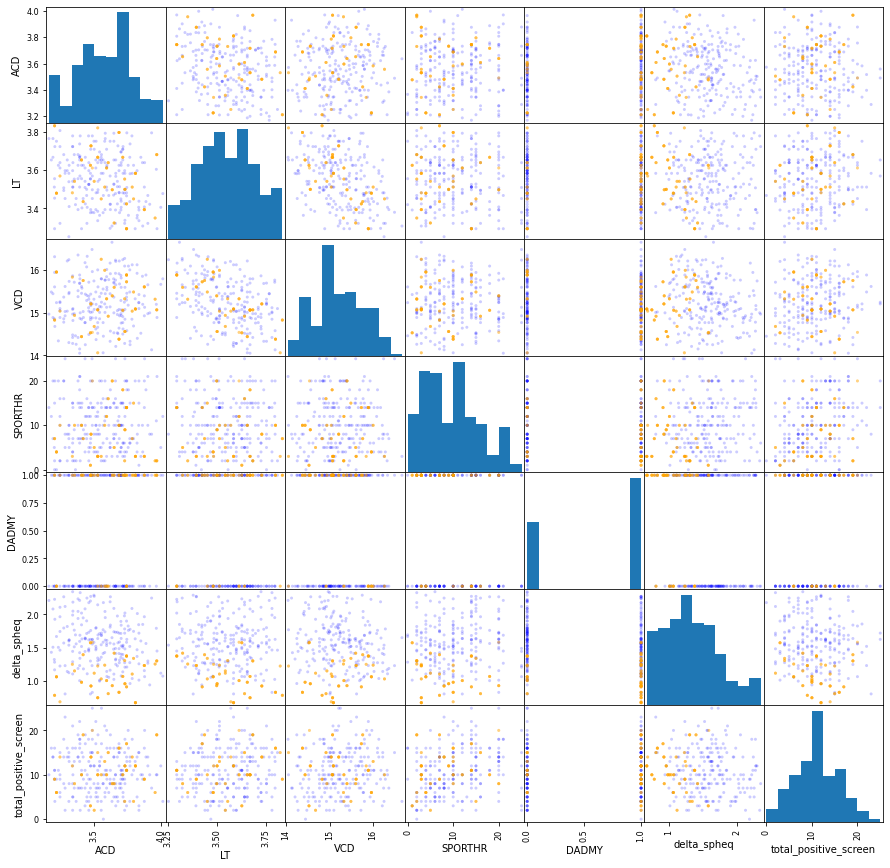

In [11]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_ros, alpha=0.2, figsize=(15,15), c=y_ros.map(colors) );

In [12]:
X_ros.describe()

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,3.581816,3.553529,15.227201,9.387560,0.624402,1.338675,10.868421
std,0.199513,0.138564,0.543640,5.829968,0.484857,0.394502,4.744241
min,3.168000,3.252000,14.050000,0.000000,0.000000,0.678000,0.000000
25%,3.436000,3.450000,14.880000,4.000000,0.000000,1.034000,8.000000
50%,3.596000,3.554000,15.200000,9.000000,1.000000,1.304000,10.000000
75%,3.732000,3.654000,15.650000,14.000000,1.000000,1.584000,14.000000
max,4.013000,3.833000,16.660000,25.000000,1.000000,2.341000,25.000000


In [13]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', ros), ('model', RandomForestClassifier(n_estimators=150, random_state=1))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.243
Mean recall: 0.214
Mean precision: 0.325
Mean ROC AUC: 0.792
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Balancing Data - SMOTE
- synthetic minority over-sampling technique

In [14]:
# Compared to the raw data scatter, the data is spread but very close to the existing datapoints
# Theoretically, there should be more points between the existing points such that `almost narrow paths` are created between the original samples
oversample = SMOTE(random_state=42)
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [15]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 209, 1: 31})
Resample dataset shape Counter({0: 209, 1: 209})


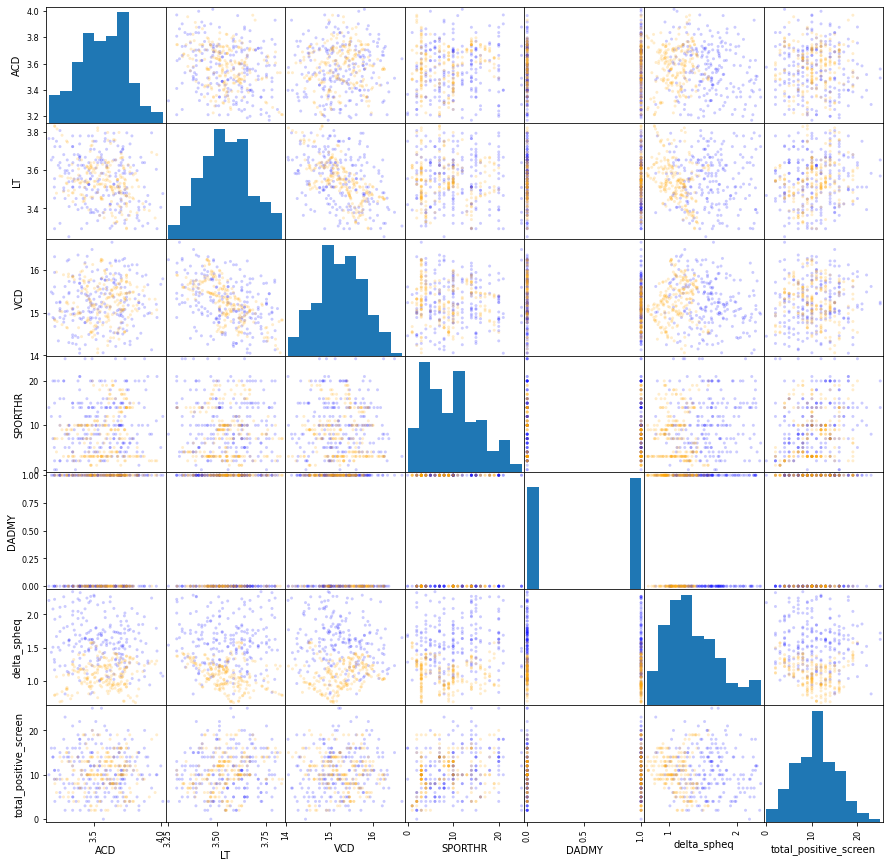

In [16]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_smote, alpha=0.2, figsize=(15,15), c=y_smote.map(colors) );

In [17]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', SMOTE(random_state=42)), ('model', RandomForestClassifier(n_estimators=150, random_state=1))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.323
Mean recall: 0.417
Mean precision: 0.276
Mean ROC AUC: 0.786
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Balacing Data - SMOTE with Undersampling

In [18]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints scattered but there still exists an imbalance
# The dataset is smaller since the minority class was increasted and the majority class descreased in samples
# The distributions have some signficant differences
# In theory, the new samples will not follow a narrow path but a broad path giving it an appearance of randomness. 
# the new samples can also veer toward other paths if the paths become close to each other.  This can cause changes in the distributions.  
# This is probably a good method if the dataset is large and highly imbalanced initially.  

print('Original dataset shape', Counter(y_train))
print('Minority fraction of entire dataset:  ', Counter(y_train)[1]/(Counter(y_train)[0]+Counter(y_train)[1]))

Original dataset shape Counter({0: 209, 1: 31})
Minority fraction of entire dataset:   0.12916666666666668


In [19]:
# sampling_strategy 
# - total number of samples increases
# - minority class changes from 30 to 84 and majority remains at 210.
# - Math:  sampling_strategy_input=(30+x)/210=0.4 then minority_samples=30+x

# To make it easier, lets enter how much of the overall datast you want the minority class to be
minority_fraction_minority_insert = 0.2
over_sampling_strategy = minority_fraction_minority_insert/(1-minority_fraction_minority_insert)

# create oversampling of minority class plan
over = SMOTE(sampling_strategy=over_sampling_strategy)

# sampling_strategy 
# - total number of samples decreases
# - minority class remains at 84 but the majority class decreases from 210 to 168.
# - Math:  84/(210-x)=0.5 then majority_samples=210-x

# To make it easier,, lets enter how much of the overall dataset you want the minority class to be
minority_fraction_majority_remove = 0.30
under_sampling_strategy = (1/minority_fraction_majority_remove - 1)**-1


under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)

In [20]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [21]:
# transform the dataset
X_under_smote, y_under_smote = pipeline.fit_resample(X_train, y_train)

In [22]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_under_smote))

Original dataset shape Counter({0: 209, 1: 31})
Resample dataset shape Counter({0: 121, 1: 52})


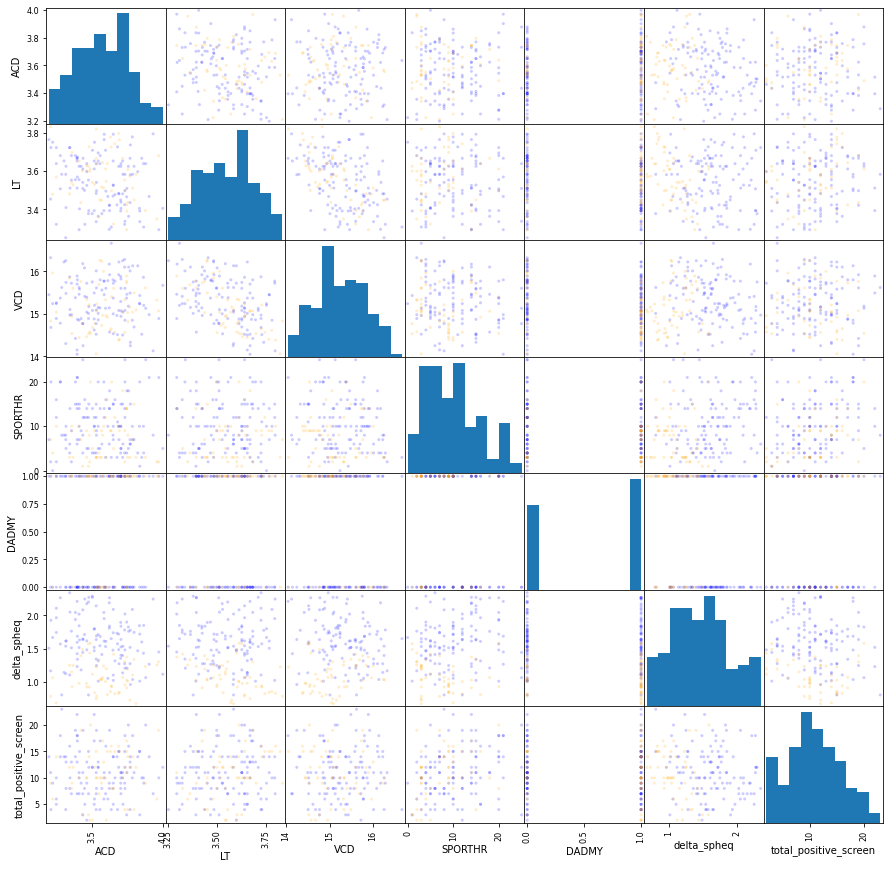

In [23]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_under_smote, alpha=0.2, figsize=(15,15), c=y_under_smote.map(colors) );

In [24]:
# To make it easier, lets enter how much of the overall datast you want the minority class to be
minority_fraction_minority_insert = 0.2
over_sampling_strategy = minority_fraction_minority_insert/(1-minority_fraction_minority_insert)

# create oversampling of minority class plan
over = SMOTE(sampling_strategy=over_sampling_strategy, random_state=42)

# To make it easier,, lets enter how much of the overall dataset you want the minority class to be
minority_fraction_majority_remove = 0.30
under_sampling_strategy = (1/minority_fraction_majority_remove - 1)**-1

under = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)

In [25]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', over), ('under', under), ('model', RandomForestClassifier(n_estimators=150, random_state=1))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.318
Mean recall: 0.372
Mean precision: 0.301
Mean ROC AUC: 0.801
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Balancing Data - Sampling Low Density Areas
- Adaptive Synthetic Sampling

In [26]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints spread but similar to the SMOTE method
# In theory, it adds samples to the low density areas and does not change the high density areas
oversample = ADASYN(random_state=42)
X_low_density, y_low_density = oversample.fit_resample(X_train, y_train)

In [27]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_low_density))

Original dataset shape Counter({0: 209, 1: 31})
Resample dataset shape Counter({0: 209, 1: 200})


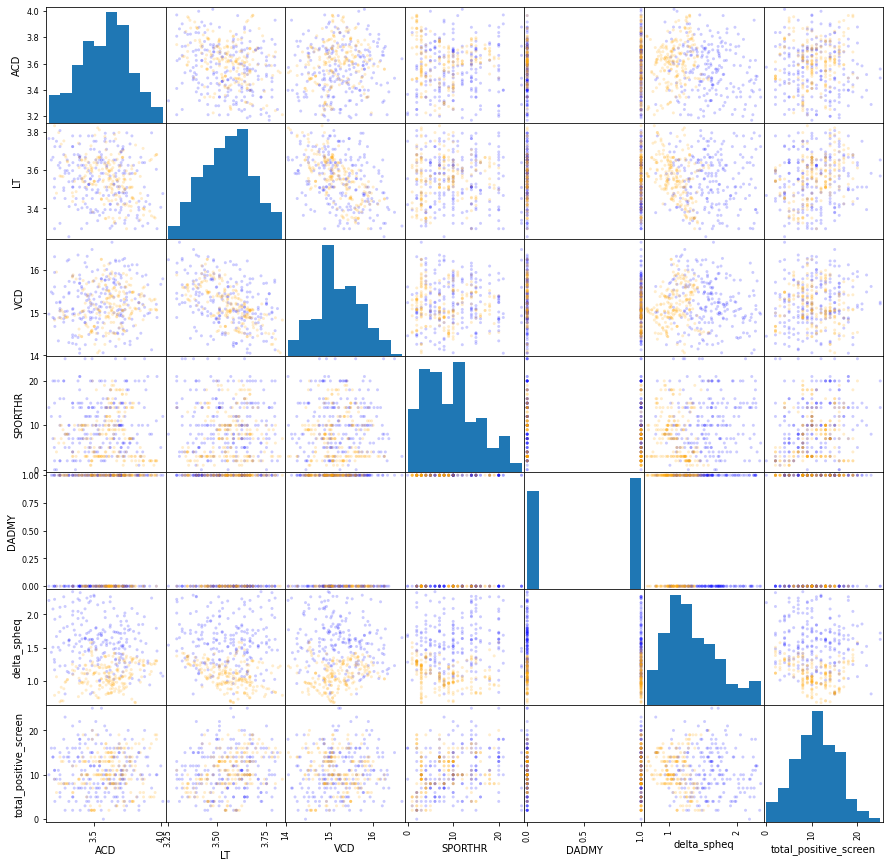

In [28]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_low_density, alpha=0.2, figsize=(15,15), c=y_low_density.map(colors) );

In [29]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', ADASYN(random_state=42)), ('model', RandomForestClassifier(n_estimators=150, random_state=1))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.307
Mean recall: 0.417
Mean precision: 0.254
Mean ROC AUC: 0.788
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Balancing Data - Oversampling Misclassified

In [30]:
# Compared to the raw data scatter, the below scatter plot shows the datapoints spread but less drastically
# Often used to identify hard to classify datapoints.  The models that work well are KNN and SVM
# In theory, samples are added from the misclassified minority class as identified by KNN.  New samples are added along the 
# decision border but not within a boundary of majority class samples.  This prevents paths from forming to outliers.
# Note:  There is also a SVMSMOTE() which uses SVC to find the misclassified.

oversample = BorderlineSMOTE(random_state=42)
X_over_misc, y_over_misc = oversample.fit_resample(X_train, y_train)

In [31]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_over_misc))

Original dataset shape Counter({0: 209, 1: 31})
Resample dataset shape Counter({0: 209, 1: 209})


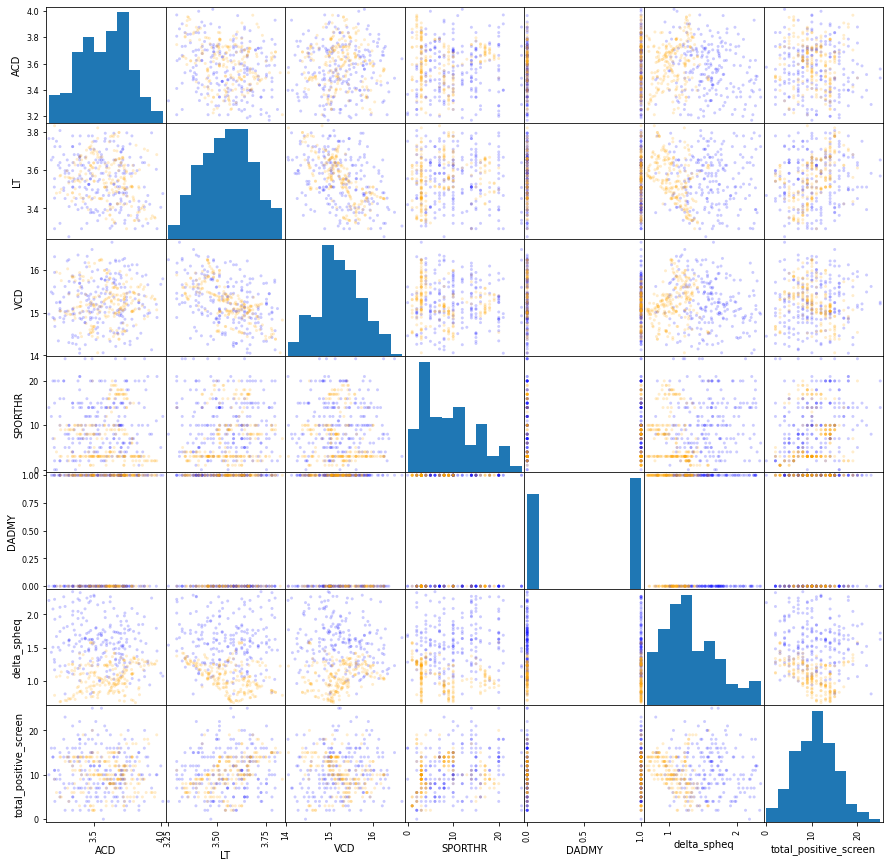

In [32]:
# balanced data
colors = {0:'blue', 1:'orange'}
pd.plotting.scatter_matrix(X_over_misc, alpha=0.2, figsize=(15,15), c=y_over_misc.map(colors) );

In [33]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', BorderlineSMOTE(random_state=42)), ('model', RandomForestClassifier(n_estimators=150, random_state=1))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.291
Mean recall: 0.350
Mean precision: 0.264
Mean ROC AUC: 0.786
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## SMOTE-NC - Used for mixed datatypes like Nominal and Continuous
- To Be Continued

## Other Methods
*  Imbalancelearn NearMiss() - uses KNN to undersample
*  Imbalancelearn CondensedNearestNeighbor() aka CNN - uses KNN to undersample but uses the misclassified majority class to penalize
*  Imbalancelearn TomekLinks() - Similar to CNN but uses redundant samples - doesn't appear to do a good job of balancing.


## Classifier with Stratified Cross Validation

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statistics import mean, mode

In [35]:
model = DecisionTreeClassifier()
# evaluate pipeline
# for 5 fold cv, repeat ~100 times; for 10 fold cv, repeat ~50 times
scoring = ('f1', 'recall', 'precision', 'roc_auc')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=1)
scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

In [36]:
print(f'Mode of Scores: {mode(scores["test_roc_auc"])}')
print("--------"*10)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mode of Scores: 0.6190476190476191
--------------------------------------------------------------------------------
Mean f1: 0.306
Mean recall: 0.341
Mean precision: 0.307
Mean ROC AUC: 0.614


In [37]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        24
           1       0.33      0.33      0.33         3

    accuracy                           0.85        27
   macro avg       0.62      0.62      0.62        27
weighted avg       0.85      0.85      0.85        27



## Pipeline with SMOTE and Stratified Cross Validation
- Good explanation of stratified sampling - https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb

In [39]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)

In [40]:
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.305
Mean recall: 0.383
Mean precision: 0.279
Mean ROC AUC: 0.609


In [41]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Pipeline with Stratified Cross Validation and Random Forest (imbalanced)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [44]:
irfc = RandomForestClassifier(n_estimators=150, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=1)

In [45]:
# Printout of the folds
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
for train_index, test_index in cv.split(X_train_np, y_train_np):
    
    # select rows
    train_X, test_X = X_train_np[train_index], X_train_np[test_index]
    train_y, test_y = y_train_np[train_index], y_train_np[test_index]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=168, 1=24, Test: 0=41, 1=7
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=168, 1=24, Test: 0=41, 1=7
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=168, 1=24, Test: 0=41, 1=7
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=167, 1=25, Test: 0=42, 1=6
>Train: 0=168, 1=24, Test: 0=41, 1=7


In [46]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('model', irfc)]
pipeline = Pipeline(steps=steps)

In [47]:
#Evaluate irfc model
'''
When using X_train, y_train, the following warning occurs:
UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to 
no predicted samples. Use `zero_division` parameter to control this behavior

This is because some of the models don't classify any minority class.
'''
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv)

C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ejwda\Anaconda3\envs\PythonDataS2022\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('AUC: %.3f' % mean(scores['test_roc_auc']))
print('-----'*20)
print('Precision Results for each fold')
scores['test_precision']

Mean f1: 0.207
Mean recall: 0.145
Mean precision: 0.470
AUC: 0.761
----------------------------------------------------------------------------------------------------
Precision Results for each fold


array([0.        , 0.4       , 0.        , 0.        , 1.        ,
       1.        , 0.66666667, 0.5       , 0.5       , 0.        ,
       1.        , 0.5       , 0.33333333, 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.5       , 1.        ])

In [49]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90        24
           1       0.00      0.00      0.00         3

    accuracy                           0.81        27
   macro avg       0.44      0.46      0.45        27
weighted avg       0.78      0.81      0.80        27



## Pipeline with Balanced Random Forest (imbalanced)

In [51]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [52]:
brfc = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)
scoring1 = ('f1', 'recall', 'precision', 'roc_auc')

steps1 = [('model1', brfc)]
pipeline = Pipeline(steps=steps1)

In [53]:
X_train.values

array([[ 3.43600011,  3.54200005, 16.18000031, ...,  0.        ,
         1.64700002, 11.        ],
       [ 3.31599998,  3.53999996, 15.44999981, ...,  1.        ,
         1.602     , 15.        ],
       [ 3.69199991,  3.37800002, 15.68000031, ...,  1.        ,
         1.588     ,  7.        ],
       ...,
       [ 3.67600012,  3.51399994, 15.05000019, ...,  0.        ,
         1.977     , 16.        ],
       [ 3.99799991,  3.4059999 , 15.67000008, ...,  1.        ,
         1.12000001, 12.        ],
       [ 3.78399992,  3.77999997, 14.85000038, ...,  0.        ,
         2.09000003, 10.        ]])

In [54]:
y_train.shape

(240,)

In [55]:
#Evaluate SRF model
# Note needed to upgrade imbalance-learn to at least 0.9.1 and scikit-learn to at least 1.1.1
scores = cross_validate(pipeline, X_train.values, y_train.values, cv=cv, scoring=scoring1)
#brfc.fit(X_train.values.reshape(-1, 1), y_train)

In [56]:
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.432
Mean recall: 0.783
Mean precision: 0.303
Mean AUC: 0.814


In [57]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        24
           1       0.14      0.33      0.20         3

    accuracy                           0.70        27
   macro avg       0.52      0.54      0.51        27
weighted avg       0.82      0.70      0.75        27

